# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
# Select all rows in the second column of the dataset, then .values return the numpy array
training_set = dataset_train.iloc[:, 1].values

training_set


array([325.25, 331.27, 329.83, ..., 793.7 , 783.33, 782.75])

In [4]:
# ':' signifies grab all the rows
# In pandas, when you use `iloc` with a single integer as the column index, it returns a Series. But when you use a range of integers (even if it's a range of one, like `1:2`), it returns a DataFrame.
# In your case, `dataset_train.train.iloc[:, 1:2]` is used to return a DataFrame. The `.values` at the end then converts this DataFrame into a numpy array.
training_set = dataset_train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
# this keeps the feature value between the numerical value of 0 and 1.
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Creating a data structure with 60 timesteps and 1 output

In [6]:
# 60 timesteps means the RNN will look at the 60 stock price before time T (i.e. the last 60 financial days of stock price, i.e. 3 months because stock market don't open on weekends)
# i.e. given these past 60 timestep, we will predict the next day's output


X_train = []
y_train = []

# We have 1258 observations in the training set; range(60, 1258) means that we will start from the 60th day, and 'i' will go all the way to the end of the training set
for i in range(60, 1258):
    # first iteration, i=60, so i=60 = 0. 0:60 means we will get the first 60 stock prices (index 0 to 59, because upper bound not included)
    # we need to have another ,0 when accessing training_set_scaled because it's a 2D array so we need to specify column 0
    X_train.append(training_set_scaled[i-60:i, 0])
    # this is the 61st stock price because it takes index i=60 (remember index starts from 0, so i=60 means 61th)
    y_train.append(training_set_scaled[i, 0])

# if you understood the code above, you know that there will be quite a bit of duplication. This is because in the first iteration, i=60, then we have 60 datapoints in X_train (1st to 60th of the datapoint) and the 61th datapoint in y_train
# in the second iteration, i=61, so then we have again 60 datapoints in X_train (2nd to the 61th of the datapoint) and the 62th datapoint in y_train (because i=61 refers to the 62th datapoint given that index starts from zero)

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape

(1198, 60)

### Reshaping

In [7]:
# we are adding some dimension so we can add extra features to help better predict the google stock price (rather than only relying on the open price)

# TLDR; if you're wondering what shape we need, can check out https://keras.io/api/layers/recurrent_layers/lstm/
# the input should be as follows:
# inputs: A 3D tensor, with shape (batch, timesteps, feature).
# batch: number of observations (i.e. 1258 rows of data)
# timesteps: 60, as we defined above
# feature: 1, because we only have 1 feature (open price)
# first param: the input array you want to reshape
# second param: new input shape (in a tuple)
# the reason we included X_train.shape[0] is because that represents the number of observations (i.e. 1258 rows of data), X_train.shape[1] is the number of columns/timesteps (i.e. 60)
# last value is 1 because we are only adding 1 indicator here
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
X_train.shape

(1198, 60, 1)

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# Add dropout class to do dropout regularization
from keras.layers import Dropout

### Initialising the RNN

In [10]:
# We are intializing RNN as sequence of layer as compared to computational graph
# We will use pytorch in the later parts to build dynamic graphs
# we're predicting a continuous value output
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [11]:
# The dropout regularization is applied in order to prevent overfitting
# Add LSTM object
# units = number of LSTM unit/memory cells
# return_sequences = True (as long as you are adding "stacked" or multi-layer LSTM neural network layer)
# input_shape = shape of your x_train (3D, containing your observation, timestep, and indicator)
# we want high dimensionality for our model (larger number of neurons = larger dimensionality)
# the next layer will also have the same number of neurons
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# add the rates of dropout - here, we're dropping 20% of neuron in forward and backpropagation: 20% of 50 neuron is 10 neurons
# purpose here is to reduce overfitting
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [12]:
# tutor kept saying 50 neurons = high dimensionality but i don't get it.
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [13]:
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [14]:
# no longer need return_sequence=True because it's the last LSTM layer (by default it is falses)
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [15]:
# same as for CNN and ANN, we just need to add the Dense class
# unit = 1 because we are only predicting a single continuous value, i.e. the stock price
regressor.add(Dense(units=1))

### Compiling the RNN

In [16]:
# RMSprop is an option as well
# TLDR; just try all the different kinds; we use MSE because predicting stock price which is continuous value
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [17]:
# stochastic gradietn descent with 32.
# regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

### Saving The Model File

In [18]:
# save the model file
# regressor.save('model.keras')

### Loading The Model File

In [19]:
from keras.models import load_model

# returns a compiled model identical to the previous one
regressor = load_model('model.keras')

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [20]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
dataset_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [21]:
testing_set = dataset_test.iloc[:, 1:2].values
testing_set

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

### Getting the predicted stock price of 2017

- Key point 1: We trained the model to use 60 past stock days to predict the next day's stock price; so if we are predicting 2017 January 1st stock price, we need the PAST 60 days data to predict that. The same applies to January 2nd, we need the past 60 days, etc.

- Key point 2: this means that you need to use both training and test dataset (because train dataset has data from 2012 to 2016) and test dataset has data from 2017 onwards; so we need to do some concatenation

- Key point 3: The way we make that concatenation is important. We need to scale the test dataset as well, but we need to use the same scaler as the one we used for the training dataset. This is because we need to have the same scaling for both training and test dataset, otherwise the model will not be able to predict the test dataset properly.

We cannot concetenate the `training_set` abd `testing_set` directly because eventually we need to apply feature scaling. This means that our `testing_set` may end up having a scaled value and we would change the testing value - which is not ideal.

So what we need to do is to use a new variable / orginal variable like `dataset_train` which is a fresh copy of the instance. We will then scale these input without directly touching the `testing_set`.

TLDR; we dont' want to change any value of the `testing_set`.

In [22]:
# concatenate the dataset (along the vertical axis), i.e. stack it like a hamburger to make it taller and taller (rather than fatter on its sides)
dataset_combined = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

dataset_combined

0     325.25
1     331.27
2     329.83
3     328.34
4     322.04
       ...  
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, Length: 1278, dtype: float64

In [23]:
# btw dataset_train['Open] gets you a pandas series; a series can be considered as a single column of data.
dataset_train['Open']

0       325.25
1       331.27
2       329.83
3       328.34
4       322.04
         ...  
1253    790.90
1254    790.68
1255    793.70
1256    783.33
1257    782.75
Name: Open, Length: 1258, dtype: float64

In [25]:
# len(dataset_total) - len(dataset_test) - 60 calculates the starting index for slicing. It takes the total length of the concatenated dataset, subtracts the length of the test dataset, and further subtracts 60. This essentially means "start from 60 elements before the beginning of the test dataset".
# The : in slicing indicates that all elements from this starting index to the end of the dataset_total are included.
# output would be 80 elements in the 'inputs' dataset
inputs = dataset_combined[len(dataset_combined) - len(dataset_test) - 60:].values
print('Length of Input: ' + str(len(inputs)))
# inputs.reshape(-1, 1) reshapes the inputs array.
# The -1 in the reshape method is a placeholder that tells NumPy to automatically calculate the number of rows needed based on the length of the array.
# The 1 indicates that you want 1 column.
inputs = inputs.reshape(-1 ,1)
inputs


Length of Input: 80


array([[779.  ],
       [779.66],
       [777.71],
       [786.66],
       [783.76],
       [781.22],
       [781.65],
       [779.8 ],
       [787.85],
       [798.24],
       [803.3 ],
       [795.  ],
       [804.9 ],
       [816.68],
       [806.34],
       [801.  ],
       [808.35],
       [795.47],
       [782.89],
       [778.2 ],
       [767.25],
       [750.66],
       [774.5 ],
       [783.4 ],
       [779.94],
       [791.17],
       [756.54],
       [755.6 ],
       [746.97],
       [755.2 ],
       [766.92],
       [771.37],
       [762.61],
       [772.63],
       [767.73],
       [764.26],
       [760.  ],
       [771.53],
       [770.07],
       [757.44],
       [744.59],
       [757.71],
       [764.73],
       [761.  ],
       [772.48],
       [780.  ],
       [785.04],
       [793.9 ],
       [797.4 ],
       [797.34],
       [800.4 ],
       [790.22],
       [796.76],
       [795.84],
       [792.36],
       [790.9 ],
       [790.68],
       [793.7 ],
       [783.33

In [26]:
# tutor mentioned that we need to have the same 3 dimension datastructure we create above
# we're using our past scaling factor and applying it to this new inputs - actually i wonder if this is valid?
inputs = sc.transform(inputs)

X_test = []
# there are 80 eleents in inputs after we do the slicing because we are predicting 20 financial days. We need 60 previous financial days to predict so 20 + 60 = 80
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)

# we need to inverse transform to see the actual stock price unscaled.
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 2s 2s/step


### Visualising the results

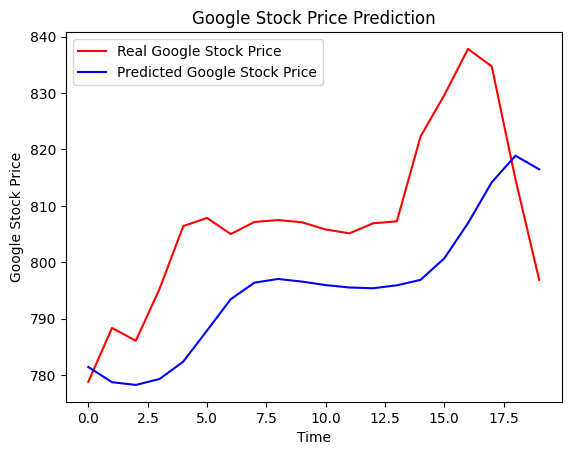

In [27]:
# testing_set contains the Real Google Stock price in 2017 month of January
plt.plot(testing_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# some part of our prediction are lagging behind; our model lacks behind because it cannot react to fast, non-linear changes (i.e. the sharp downward trend is that sharp non-linear change)
# however, the model generally capture the upwards/downwards trend really well